<a href="https://colab.research.google.com/github/sblakebridges/F24-public/blob/main/Reinforcement_Learning_Trading_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
!pip install ta
!pip install --upgrade tensorflow keras tensorflow-addons
!pip install stable-baselines3 gym gym-anytrading numpy pandas matplotlib
!pip install --upgrade shimmy gymnasium stable-baselines3



In [27]:
import yfinance as yf
import pandas as pd
import numpy as np

# Define the stock ticker and timeframe
ticker = "AAPL"  # Change this to any stock symbol
start_date = "2020-01-01"
end_date = "2024-01-01"

# Download historical stock data
df = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Ensure data is sorted in ascending order
df.sort_index(inplace=True)

# Feature Engineering (Manual Calculation)

# Simple Moving Averages (SMA)
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# Relative Strength Index (RSI) Calculation
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Moving Average Convergence Divergence (MACD)
short_ema = df['Close'].ewm(span=12, adjust=False).mean()  # 12-day EMA
long_ema = df['Close'].ewm(span=26, adjust=False).mean()   # 26-day EMA
df['MACD'] = short_ema - long_ema
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()  # Signal line

# Bollinger Bands (20-day moving average ± 2 standard deviations)
df['Middle_BB'] = df['Close'].rolling(window=20).mean()
df['Rolling_Std'] = df['Close'].rolling(window=20).std()  # Ensure this is a Series
df['Upper_BB'] = df['Middle_BB'] + (df['Rolling_Std'] * 2)
df['Lower_BB'] = df['Middle_BB'] - (df['Rolling_Std'] * 2)

# Drop the Rolling_Std column after calculation
df.drop(columns=['Rolling_Std'], inplace=True)

# 🔹 NEW FEATURES 🔹

# Daily Returns (Momentum Indicator)
df['Daily_Returns'] = df['Close'].pct_change()

# Cumulative Returns (Long-Term Trend Indicator)
df['Cumulative_Returns'] = (df['Close'] / df['Close'].iloc[0]) - 1

# Volatility (Rolling Standard Deviation)
df['Volatility_10'] = df['Close'].rolling(window=10).std()

# Trading Volume (Market Strength Indicator)
df['Trading_Volume'] = df['Volume']

# Target Variable: Predict if price goes up (1) or down (0) the next day
df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

# Drop NaN values caused by indicator calculations
df.dropna(inplace=True)

# Display the first few rows of the dataset
print(df.head())

# Save to CSV (Optional: For easier data analysis)
df.to_csv("stock_data_with_features.csv", index=True)


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume     SMA_10  \
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL              
Date                                                                           
2020-03-13  67.531662  68.005409  61.453155  64.353933  370732000  68.655523   
2020-03-16  58.843918  62.942410  58.307006  58.780750  322423600  67.280451   
2020-03-17  61.431286  62.585275  57.918287  60.131524  324056000  66.394670   
2020-03-18  59.927460  60.736470  57.607326  58.251135  300233600  65.032473   
2020-03-19  59.468288  61.426431  58.941096  60.102377  271857200  63.862931   

Price          SMA_50        RSI      MACD MACD_signal  Middle_BB   Upper_BB  \
Ticker                                                                         
Date                                                                           
2020-03-13  74.204477  45.068568 -2.659556   -2.035598  71.094094  81.108389   
2020-03-16  73.925435  40.052918 -3.223

In [28]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Define the updated feature list
features = [
    'SMA_10', 'SMA_50', 'RSI', 'MACD', 'MACD_signal', 'Upper_BB', 'Middle_BB', 'Lower_BB',
    'Daily_Returns', 'Cumulative_Returns', 'Volatility_10', 'Trading_Volume'
]

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[features])

# Define sequence length (how many past days to look at)
sequence_length = 10

X_lstm, y_lstm = [], []

# Create sequences for LSTM
for i in range(sequence_length, len(X_scaled)):
    X_lstm.append(X_scaled[i-sequence_length:i])  # Past 10 days of data
    y_lstm.append(df['Target'].iloc[i])  # Target for the next day

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Split into training (80%) and testing (20%) sets
split = int(0.8 * len(X_lstm))
X_train, X_test = X_lstm[:split], X_lstm[split:]
y_train, y_test = y_lstm[:split], y_lstm[split:]

# Print dataset shape
print(f"Updated Training Set Shape: {X_train.shape}")
print(f"Updated Testing Set Shape: {X_test.shape}")



Updated Training Set Shape: (757, 10, 12)
Updated Testing Set Shape: (190, 10, 12)


In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build LSTM Model
model = Sequential([
    LSTM(units=128, return_sequences=True, input_shape=(sequence_length, len(features))),  # Increased units
    Dropout(0.2),
    LSTM(units=128),
    Dropout(0.2),
    Dense(units=1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))



Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.4595 - loss: 0.7051 - val_accuracy: 0.5368 - val_loss: 0.6917
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5307 - loss: 0.6934 - val_accuracy: 0.4579 - val_loss: 0.6940
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5252 - loss: 0.6917 - val_accuracy: 0.5368 - val_loss: 0.6922
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5223 - loss: 0.6911 - val_accuracy: 0.5263 - val_loss: 0.6931
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5129 - loss: 0.6898 - val_accuracy: 0.4316 - val_loss: 0.6951
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5597 - loss: 0.6864 - val_accuracy: 0.4632 - val_loss: 0.7019
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5632 - loss: 0.6858 - val_accuracy: 0.4632 - val_loss: 0.6977
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5348 - loss: 0.6916 - val_accuracy: 0.5526 - val_l

In [30]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Updated LSTM Test Accuracy: {test_acc:.2f}")

# Predict on test set
y_pred_lstm = (model.predict(X_test) > 0.5).astype(int)

# Classification Report
from sklearn.metrics import classification_report
print("\nUpdated Classification Report:")
print(classification_report(y_test, y_pred_lstm))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4885 - loss: 0.6968
Updated LSTM Test Accuracy: 0.51
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step

Updated Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.45      0.46        88
           1       0.54      0.56      0.55       102

    accuracy                           0.51       190
   macro avg       0.51      0.51      0.51       190
weighted avg       0.51      0.51      0.51       190



In [31]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Define the updated feature list
features = [
    'SMA_10', 'SMA_50', 'RSI', 'MACD', 'MACD_signal', 'Upper_BB', 'Middle_BB', 'Lower_BB',
    'Daily_Returns', 'Cumulative_Returns', 'Volatility_10', 'Trading_Volume'
]

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[features])

# Define sequence length (how many past days to look at)
sequence_length = 10

X_lstm, y_lstm = [], []

# Create sequences for CNN-LSTM
for i in range(sequence_length, len(X_scaled)):
    X_lstm.append(X_scaled[i-sequence_length:i])  # Past 10 days of data
    y_lstm.append(df['Target'].iloc[i])  # Target for the next day

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Reshape data for CNN (adding 1 extra channel for CNN input)
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], X_lstm.shape[2], 1))  # (samples, timesteps, features, channels)

# Split into training/testing sets
split = int(0.8 * len(X_lstm))
X_train, X_test = X_lstm[:split], X_lstm[split:]
y_train, y_test = y_lstm[:split], y_lstm[split:]

# Print dataset shape
print(f"Updated Training Set Shape: {X_train.shape}")
print(f"Updated Testing Set Shape: {X_test.shape}")


Updated Training Set Shape: (757, 10, 12, 1)
Updated Testing Set Shape: (190, 10, 12, 1)


In [49]:
!pip install --upgrade tensorflow keras tensorflow-addons

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, TimeDistributed, Input, Multiply, Reshape

# Custom Attention Layer (Final Fix)
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="attention_weight", shape=(input_shape[-1], 1), initializer="normal", trainable=True)
        self.b = self.add_weight(name="attention_bias", shape=(1,), initializer="zeros", trainable=True)

    def call(self, inputs):
        attention_scores = tf.keras.backend.dot(inputs, self.W) + self.b  # Compute scores
        attention_weights = tf.keras.backend.softmax(attention_scores, axis=1)  # Apply softmax
        context_vector = Multiply()([inputs, attention_weights])  # Apply attention weights
        context_vector = tf.reduce_sum(context_vector, axis=1, keepdims=False)  # Fix: Remove extra dim
        return context_vector  # Now shape is (None, 100) instead of (None, 1, 1)

# Build CNN-LSTM with Fixed Attention Output
input_layer = Input(shape=(10, 12, 1))  # (time steps, features, channels)

# CNN Layers
cnn_layer = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(input_layer)
cnn_layer = TimeDistributed(MaxPooling1D(pool_size=2))(cnn_layer)
cnn_layer = TimeDistributed(Flatten())(cnn_layer)

# LSTM Layer (return_sequences=True for Attention)
lstm_layer = LSTM(units=100, return_sequences=True)(cnn_layer)
dropout_layer = Dropout(0.2)(lstm_layer)

# Attention Layer (Fixed Output Shape)
attention_output = AttentionLayer()(dropout_layer)

# Fully Connected Layer
dense_layer = Dense(units=50, activation='relu')(attention_output)
dropout_layer2 = Dropout(0.2)(dense_layer)

# Output Layer (Binary Classification)
output_layer = Dense(units=1, activation='sigmoid')(dropout_layer2)  # Final shape (None, 1)

# Define Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print Model Summary
model.summary()



Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 10, 12, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_15                  │ (None, 10, 10, 64)          │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_16                  │ (None, 10, 5, 64)           │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_17                  │ (None, 10, 320)             │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 10, 100)             │         168,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 10, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_4 (AttentionLayer)   │ (None, 100)                 │             101 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 173,858 (679.13 KB)

 Trainable params: 173,858 (679.13 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# Train the CNN-LSTM with Fixed Attention Model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.5013 - loss: 0.6959 - val_accuracy: 0.5368 - val_loss: 0.6905
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5308 - loss: 0.6914 - val_accuracy: 0.5368 - val_loss: 0.6902
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5155 - loss: 0.6919 - val_accuracy: 0.5368 - val_loss: 0.6916
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5265 - loss: 0.6908 - val_accuracy: 0.5368 - val_loss: 0.6913
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5466 - loss: 0.6894 - val_accuracy: 0.4526 - val_loss: 0.6937
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5479 - loss: 0.6897 - val_accuracy: 0.5368 - val_loss: 0.6899
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.5185 - loss: 0.6918 - val_accuracy: 0.5368 - val_loss: 0.6901
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5275 - loss: 0.6890 - val_accuracy: 0

In [51]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Attention-CNN-LSTM Test Accuracy: {test_acc:.2f}")

# Predict on test set
y_pred_attention = (model.predict(X_test) > 0.5).astype(int)

# Classification Report
from sklearn.metrics import classification_report
print("\nAttention-CNN-LSTM Classification Report:")
print(classification_report(y_test, y_pred_attention))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5639 - loss: 0.6991
Attention-CNN-LSTM Test Accuracy: 0.55


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 461ms/step

Attention-CNN-LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.56      0.53        88
           1       0.59      0.54      0.56       102

    accuracy                           0.55       190
   macro avg       0.55      0.55      0.55       190
weighted avg       0.55      0.55      0.55       190



In [53]:
import gym
import gym_anytrading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import DQN

# Load Historical Stock Data
df['Date'] = pd.to_datetime(df.index)
df.set_index('Date', inplace=True)

# Define the Trading Environment
class CustomTradingEnv(gym.Env):
    def __init__(self, df, window_size=10):
        super(CustomTradingEnv, self).__init__()

        self.df = df
        self.window_size = window_size
        self.current_step = window_size

        # Define Action Space (Buy, Hold, Sell)
        self.action_space = gym.spaces.Discrete(3)

        # Define State Space (All Features)
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf, shape=(window_size, len(df.columns)), dtype=np.float32
        )

        # Track balance, shares, and profit
        self.balance = 10000  # Starting capital
        self.shares_held = 0
        self.total_profit = 0

    def reset(self):
        self.current_step = self.window_size
        self.balance = 10000
        self.shares_held = 0
        self.total_profit = 0
        return self._get_observation()

    def step(self, action):
        current_price = self.df.iloc[self.current_step]['Close']

        # Execute Trade
        if action == 0:  # Sell
            self.balance += self.shares_held * current_price
            self.shares_held = 0
        elif action == 2:  # Buy
            num_shares = self.balance // current_price
            self.balance -= num_shares * current_price
            self.shares_held += num_shares

        # Calculate Reward (Profit)
        self.total_profit = self.balance + (self.shares_held * current_price) - 10000
        reward = self.total_profit

        # Move to the Next Step
        self.current_step += 1
        done = self.current_step >= len(self.df) - 1

        return self._get_observation(), reward, done, {}

    def _get_observation(self):
        return self.df.iloc[self.current_step - self.window_size : self.current_step].values

# Create Environment
env = CustomTradingEnv(df)


In [56]:
# Create the DQN Model
model = DQN("MlpPolicy", env, verbose=1, learning_rate=0.001, batch_size=32, buffer_size=5000, exploration_fraction=0.1)

# Train the Model
model.learn(total_timesteps=10000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/monitor.py:95: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.rewards.append(float(reward))
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  obs, self.buf_rews[env_idx], terminated, truncated, self.buf_infos[env_idx] = self.envs[env_idx].step(  # type: ignore[assignment]


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 946      |
|    ep_rew_mean      | 3.13e+06 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 296      |
|    time_elapsed     | 12       |
|    total_timesteps  | 3784     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.62e+05 |
|    n_updates        | 920      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 946      |
|    ep_rew_mean      | 3.82e+06 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 328      |
|    time_elapsed     | 23       |
|    total_timesteps  | 7568     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.25e+05 |
|    n_updates      

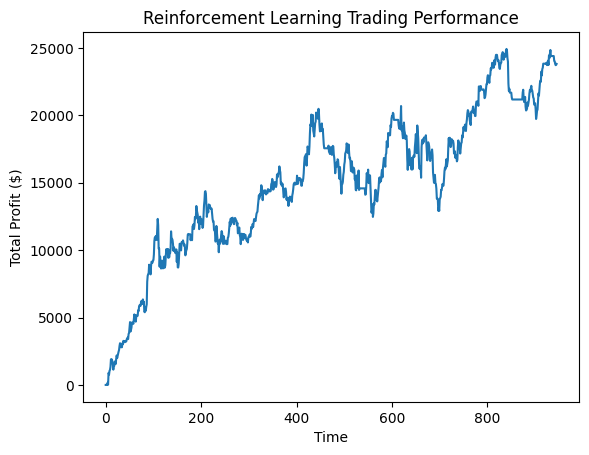

In [57]:
# Reset Environment
obs = env.reset()
done = False
profits = []

while not done:
    action, _ = model.predict(obs)  # Select Best Action
    obs, reward, done, _ = env.step(action)
    profits.append(env.total_profit)

# Plot Trading Performance
plt.plot(profits)
plt.xlabel("Time")
plt.ylabel("Total Profit ($)")
plt.title("Reinforcement Learning Trading Performance")
plt.show()
